## Tokenizing:

In [ ]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [ ]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [1]:
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [2]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [3]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [4]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang):
    lang_tokenizer = T.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

Using TensorFlow backend.


In [5]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [6]:
path_to_file_zh = r'H:\HLT\zh-Education.tok'
path_to_file_en = r'H:\HLT\en-Education.tok'

# Try experimenting with the size of that dataset
num_examples = 100#450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [7]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 839, 713


In [8]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Generate embedding vectors for <start> and <end> token
def initSpecialToken(vector_size, seed):
    np.random.seed(seed)
    return np.random.rand(vector_size)

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(trained_vector_path, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.zeros(num_tokens, vector_size)

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import gzip
import os
import tarfile
import wget

# Download pre-trained Fasttext word embeddin
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz",out = r"G:\NLP\fasttext\cc.en.300.vec.gz")
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz",out = r"G:\NLP\fasttext\cc.zh.300.vec.gz")


# Uncompressing download files
def un_gz(file_name):
    """ungz zip file"""
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "w+").write(g_file.read())
    g_file.close()
    
%cd "G:\NLP\fasttext\"
un_gz("cc.en.300.vec.gz")
un_gz("cc.zh.300.vec.gz")

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'G:\NLP\fasttext\cc.zh.300.vec', r'G:\NLP\fasttext\cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], inp_lang.word_index, vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\input_emb_matrix', input_emb_matrix)

In [ ]:
# Creating output embedding vectors and specify the <start>, <end> token
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], targ_lang.word_index, vector_size, num_decoder_tokens + 1)
start_token_vec = initSpecialToken(vector_size, 0) #'<start>'
end_token_vec = initSpecialToken(vector_size, 1) # '<end>'
output_emb_matrix[targ_lang.word_index['<start>']] = start_token_vec
output_emb_matrix[targ_lang.word_index['<end>']] = end_token_vec
# Save output embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\output_emb_matrix', output_emb_matrix)

In [9]:
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'H:\HLT\Embedding_Matrix\input_emb_matrix.npy'), np.load(r'H:\HLT\Embedding_Matrix\output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (145824, 300), (210721, 300)


In [10]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 80, 20


In [11]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 46, 42


In [12]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size = 5):
    #zero padding all sequences
    encoder_input_tensor = S.pad_sequences(input_tensor,padding='post', maxlen = max_length_inp)
    # decoder input sequence does not include the <end> token
    decoder_input_tensor = S.pad_sequences([s[:-1] for s in target_tensor],padding='post', maxlen = max_length_targ)
    # decoder target sequence (one hot encoded) does not include the <START> token, Offset by one timestep
    decoder_target_tensor = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in target_tensor],padding='post', maxlen = max_length_targ)])

    # Generate a batch of data
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = encoder_input_tensor[i:i + batch_size]
            decoder_input_batch = decoder_input_tensor[i:i + batch_size]
            decoder_target_batch = decoder_target_tensor[i:i + batch_size]
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [13]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [14]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

batch_size = 5#128
latent_dim = 300
# Set up the encoder
encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
print(encoder_inputs.shape, enc_emb.shape)
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

(5, 46) (5, 46, 300)


In [15]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
print(decoder_inputs.shape, dec_emb.shape)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder GRU output
print(decoder_outputs.shape,attn_out.shape)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
decoder_outputs = dense_time(decoder_concat_input)

(5, 42) (5, 42, 300)
(5, 42, 600) (5, 42, 600)


In [16]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (5, 46)              0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (5, 46, 300)         251700      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (5, 42)              0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(5, 46, 600), (5, 3 1081800     embedding[0][0]                  
__________________________________________________________________________________________________
embedding_

In [17]:
!apt install graphviz
!pip install pydot pydot-ng

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


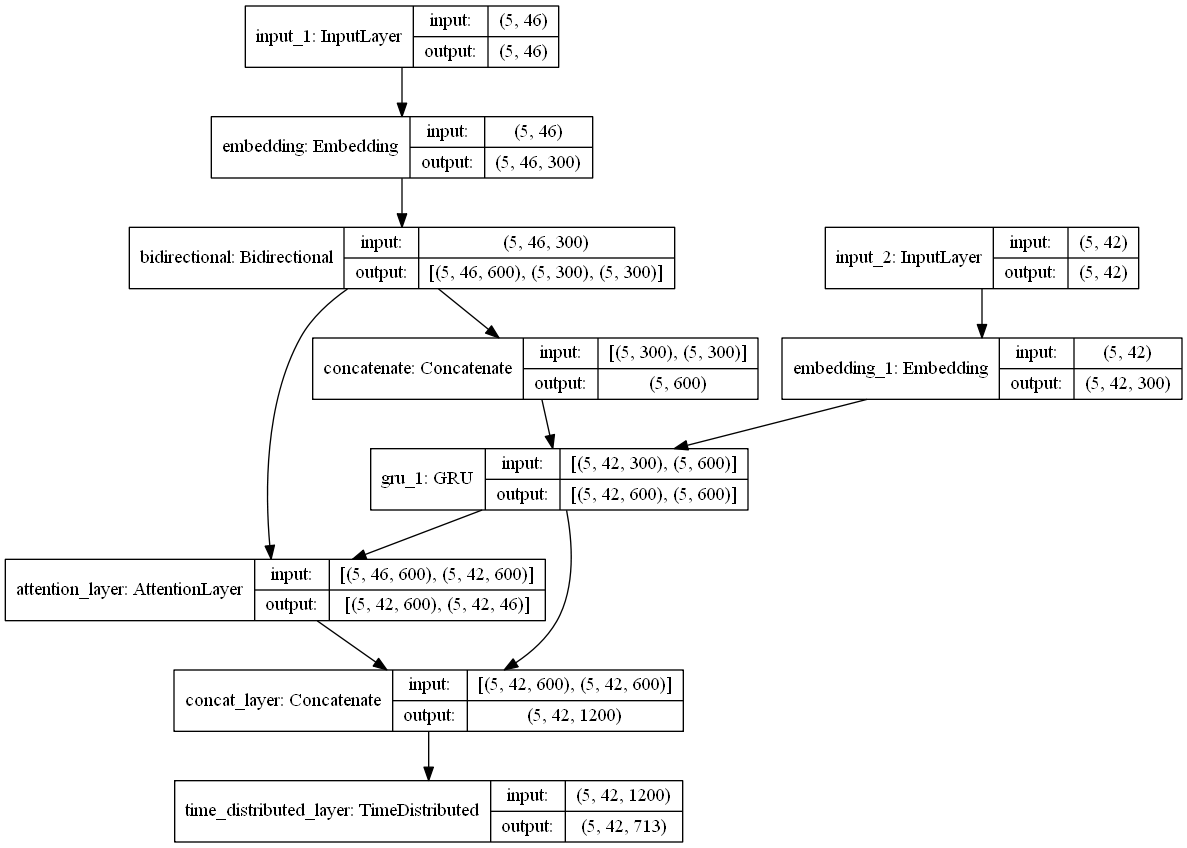

In [18]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [19]:
# Start training
epochs = 40#100
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/40
16/16 [==============================] - 54s 3s/step - loss: 3.2952 - acc: 0.4946 - val_loss: 2.8255 - val_acc: 0.5595
Epoch 2/40
16/16 [==============================] - 50s 3s/step - loss: 2.6339 - acc: 0.5607 - val_loss: 2.8895 - val_acc: 0.5845
Epoch 3/40
16/16 [==============================] - 48s 3s/step - loss: 2.4813 - acc: 0.5652 - val_loss: 2.9493 - val_acc: 0.5750
Epoch 4/40
16/16 [==============================] - 48s 3s/step - loss: 2.3346 - acc: 0.5732 - val_loss: 3.0903 - val_acc: 0.5750
Epoch 5/40
16/16 [==============================] - 47s 3s/step - loss: 2.2095 - acc: 0.5836 - val_loss: 3.1734 - val_acc: 0.5774
Epoch 6/40
16/16 [==============================] - 48s 3s/step - loss: 2.0777 - acc: 0.5896 - val_loss: 3.3210 - val_acc: 0.5738
Epoch 7/40
16/16 [==============================] - 48s 3s/step - loss: 1.9971 - acc: 0.5875 - val_loss: 3.4445 - val_acc: 0.5750
Epoch 8/40
16/16 [==============================] - 48s 3s/step - loss: 1.9716 - acc: 0.59

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


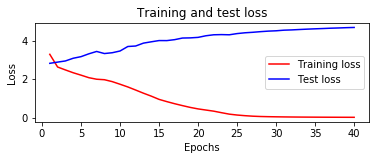

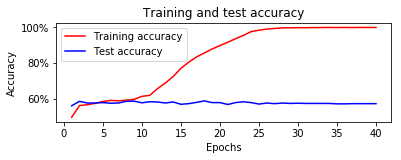

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [23]:
# Inference model
batch_size = 1

# Encoder (Inference) model
encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
# Encode the input sequence to get the "Context vectors"
encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

# Decoder (Inference) model
decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
# Get the embeddings of the decoder sequence
dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
# Final decoder model
decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],
                        outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [24]:
# Encoder model summary
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay (1, 46)                   0         
_________________________________________________________________
embedding (Embedding)        multiple                  251700    
_________________________________________________________________
bidirectional (Bidirectional multiple                  1081800   
Total params: 1,333,500
Trainable params: 1,081,800
Non-trainable params: 251,700
_________________________________________________________________


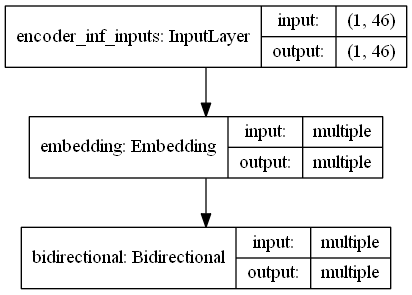

In [25]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [26]:
# Decoder model summary
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer (1, 1)               0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             213900      decoder_word_inputs[0][0]        
__________________________________________________________________________________________________
decoder_init (InputLayer)       (1, 600)             0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             1621800     embedding_1[1][0]                
                                                                 decoder_init[0][0]               
__________

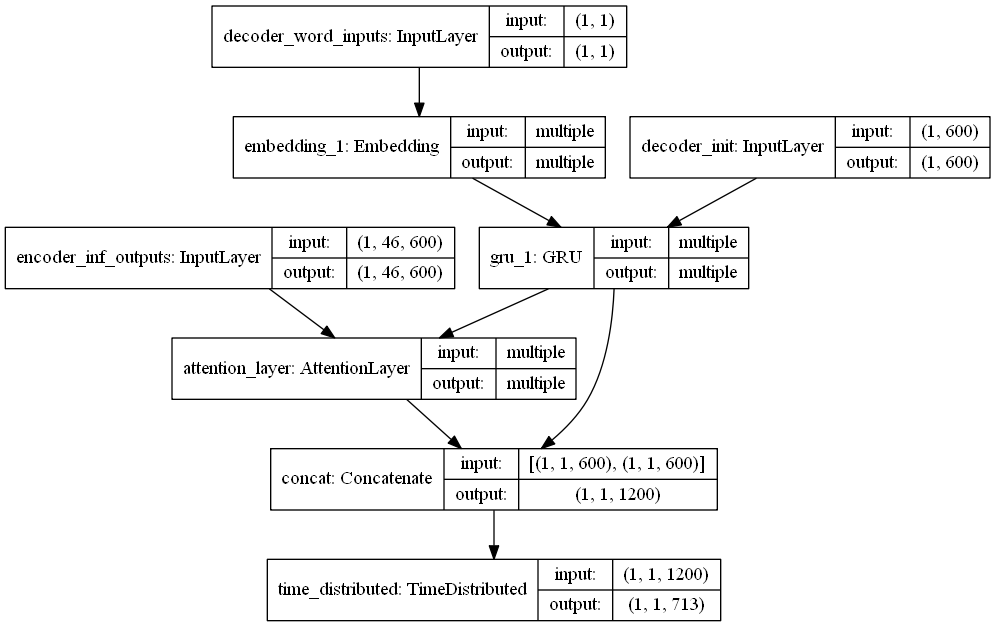

In [27]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [28]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = targ_lang.word_index['<start>']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    count = 0
    attention_weights = []
    while not stop_condition:
        output_tokens, attention, states_value = decoder_model.predict([enc_outs, states_value, target_seq])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_word_targ[sampled_token_index]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<end>' or count > max_length_targ):
            stop_condition = True
            count = 0
        else:
            attention_weights.append((sampled_token_index, attention))
            decoded_sentence += ' '+ sampled_word
            count += 1
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
    return decoded_sentence[1:],attention_weights

In [29]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

In [30]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    #ax.set_xticks(np.arange(attention_mat.shape[1]))
    #ax.set_yticks(np.arange(attention_mat.shape[0]))
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    #ax.set_yticklabels([index_word_inp[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])
    #ax.set_xticklabels([index_word_targ[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())])
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=26)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))

In [32]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 我们 宁愿 住 郊区 而 不 愿 住 城里 。
Actual Target Translation: we would rather live in the suburbs than in the city .
Predicted Target Translation: we would rather live in the suburbs than in the city .


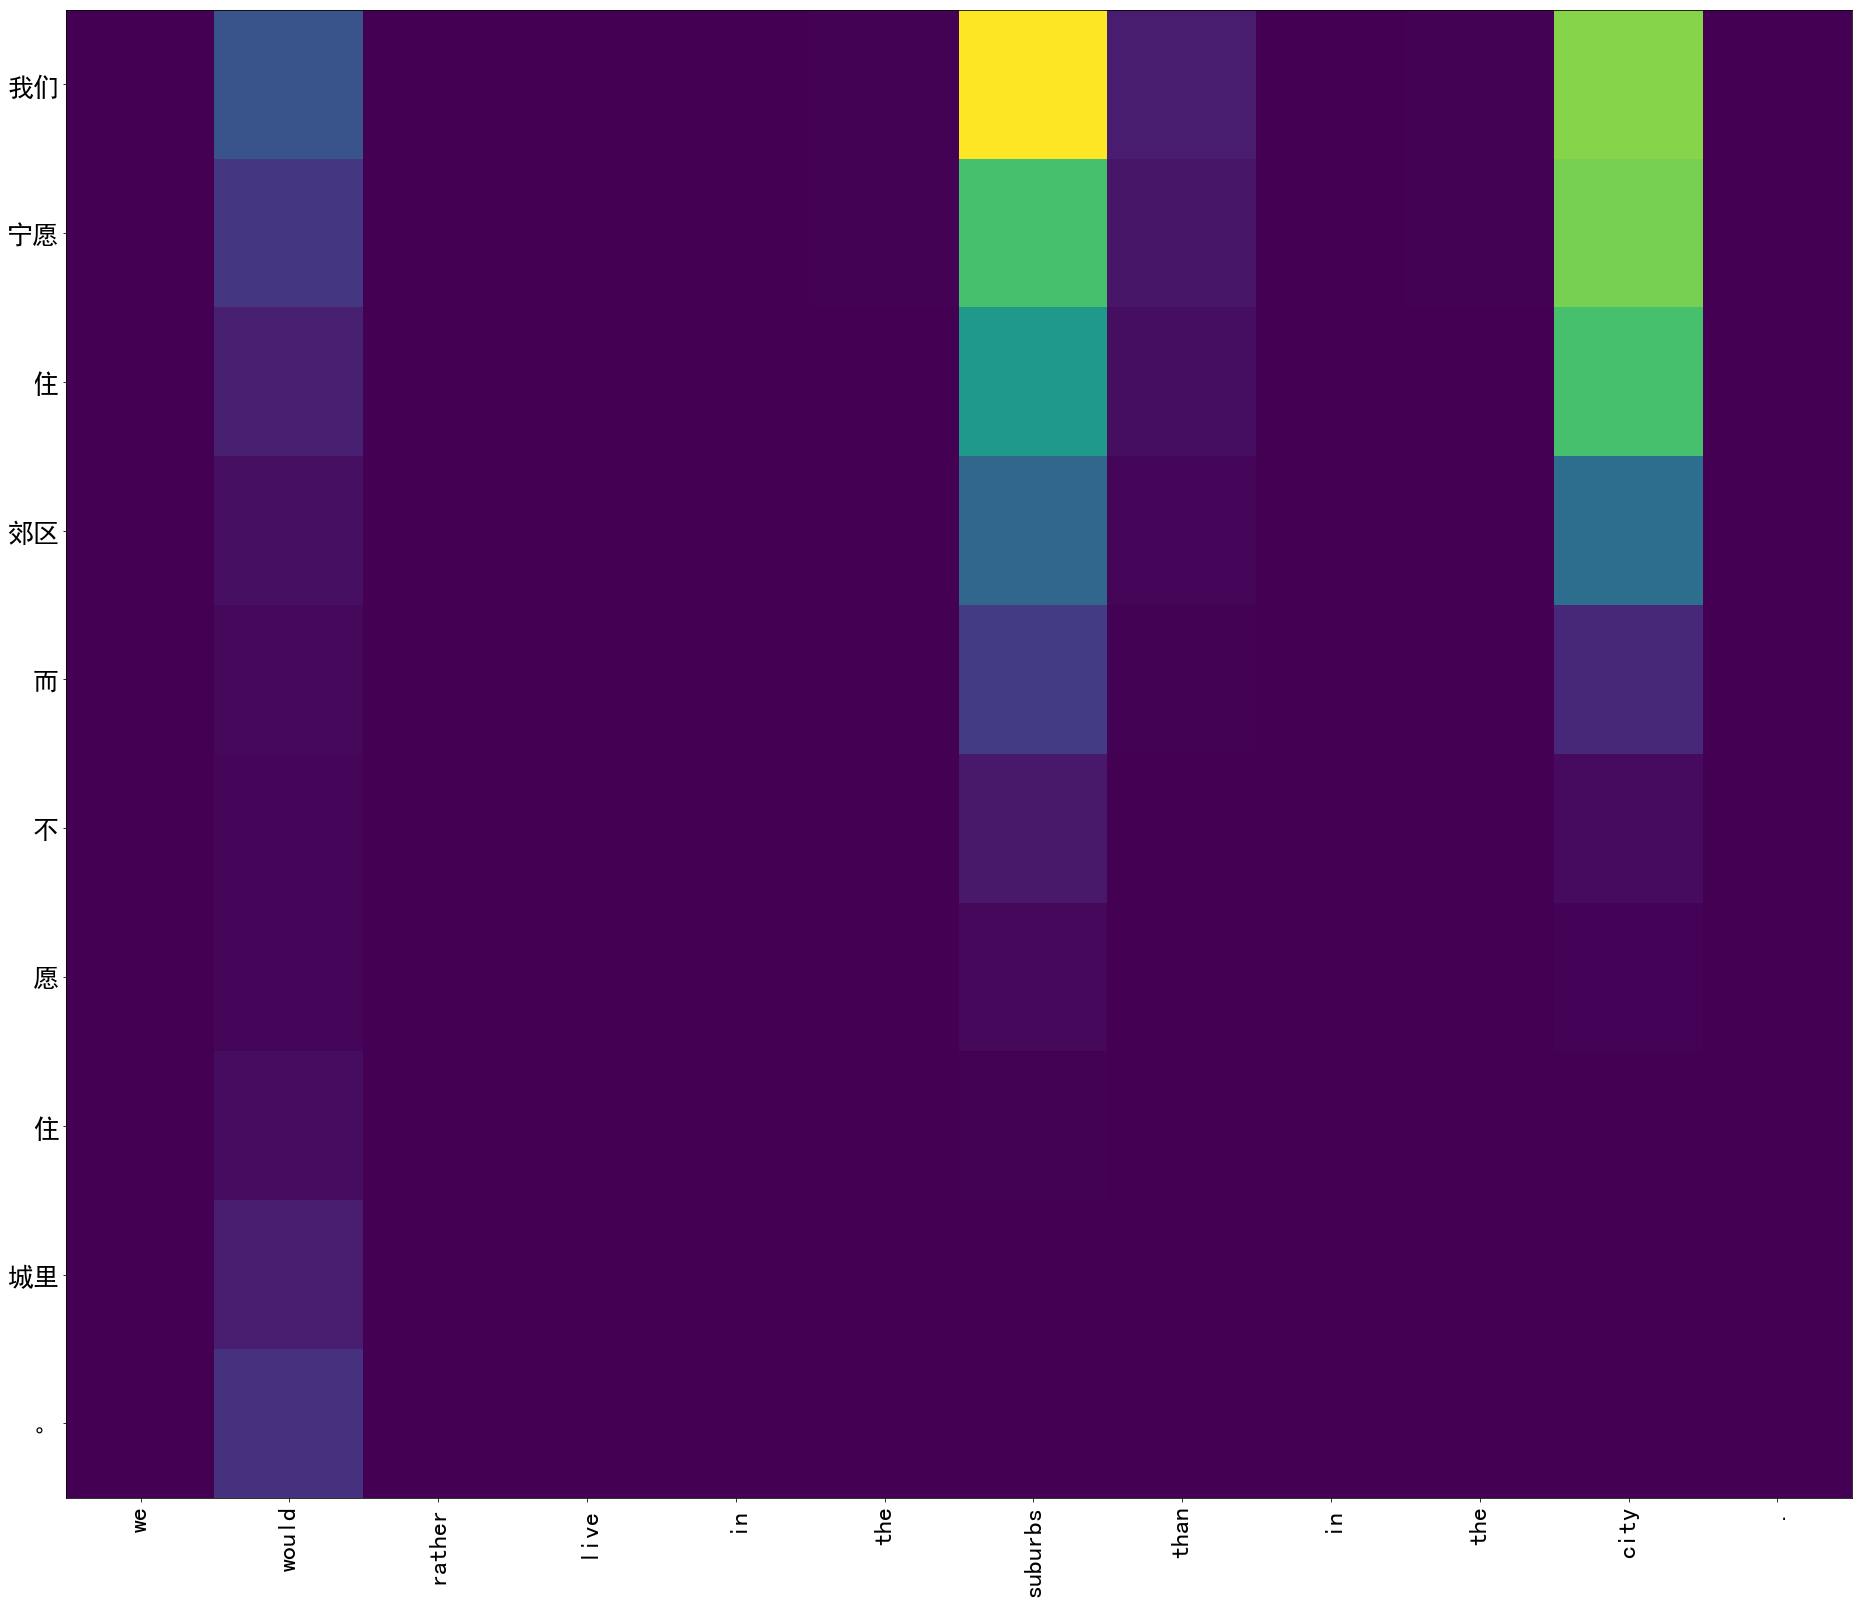

In [47]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence, attn_weights = decode_sequence(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence)
# Attention plotting
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights, index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0:10]))

Input Source sentence: 我们 宁愿 住 郊区 而 不 愿 住 城里 。
Actual Target Translation: we would rather live in the suburbs than in the city .
Predicted Target Translation: we would rather live in the suburbs than in the city .


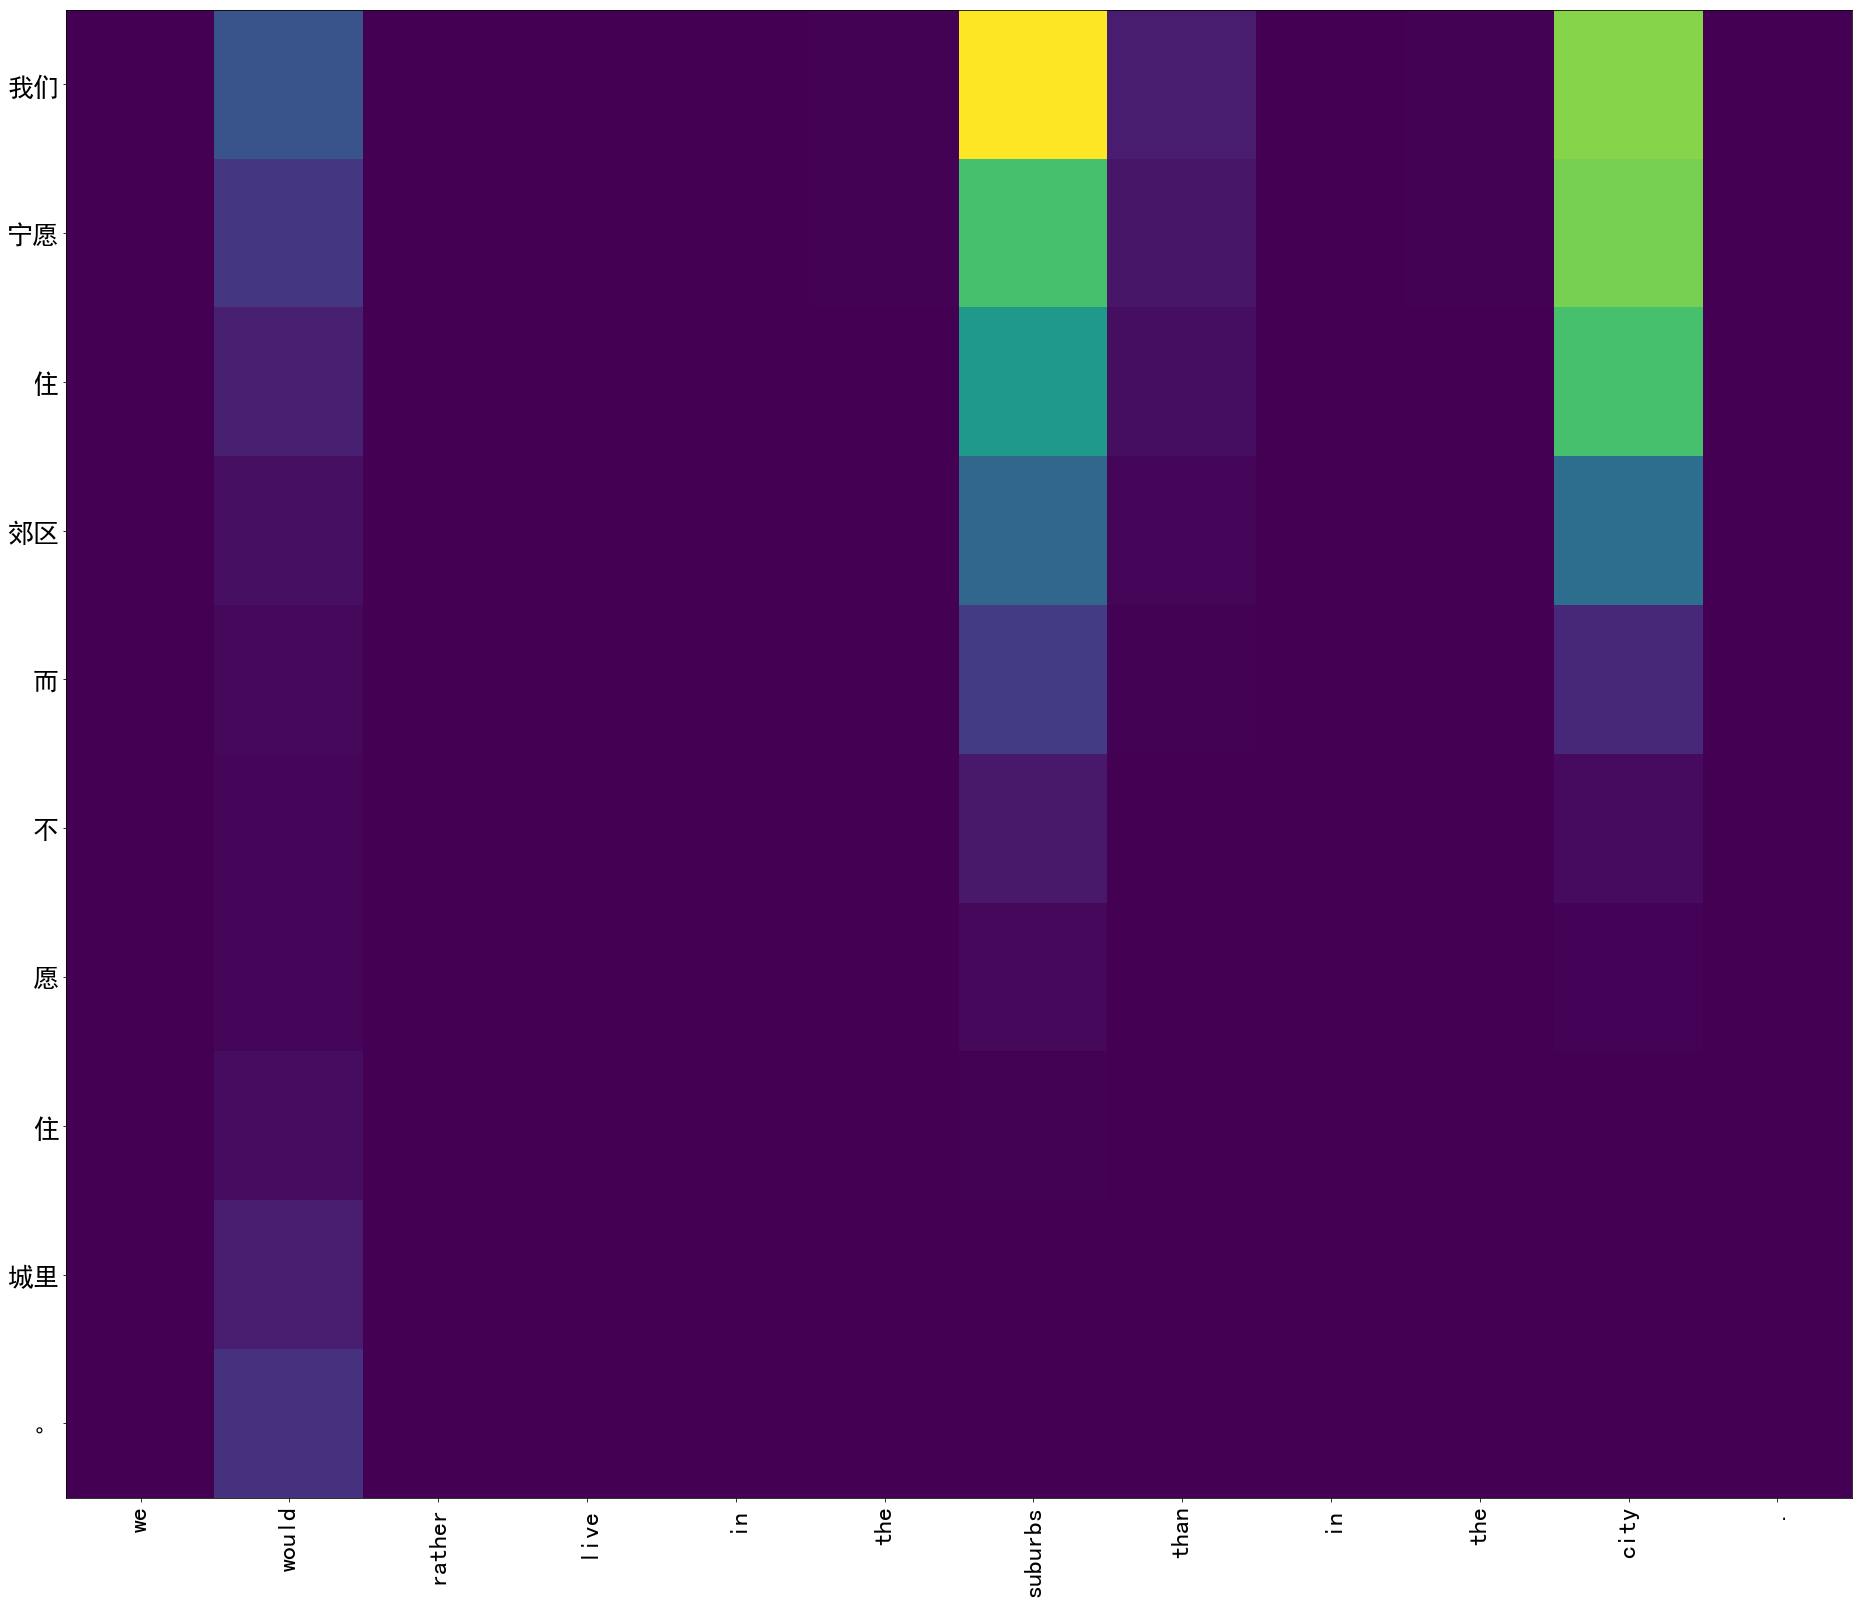

In [50]:
# Pass a source sentence and then compare the predicted output to actual output
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [35]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 她 生 于 一九八零年 九月 八日 凌晨 两点钟 。
Actual Target Translation: she was born at two o clock in the morning september eighth 1980 .
Predicted Target Translation: she put a bunch of flowers by the edge of the table .


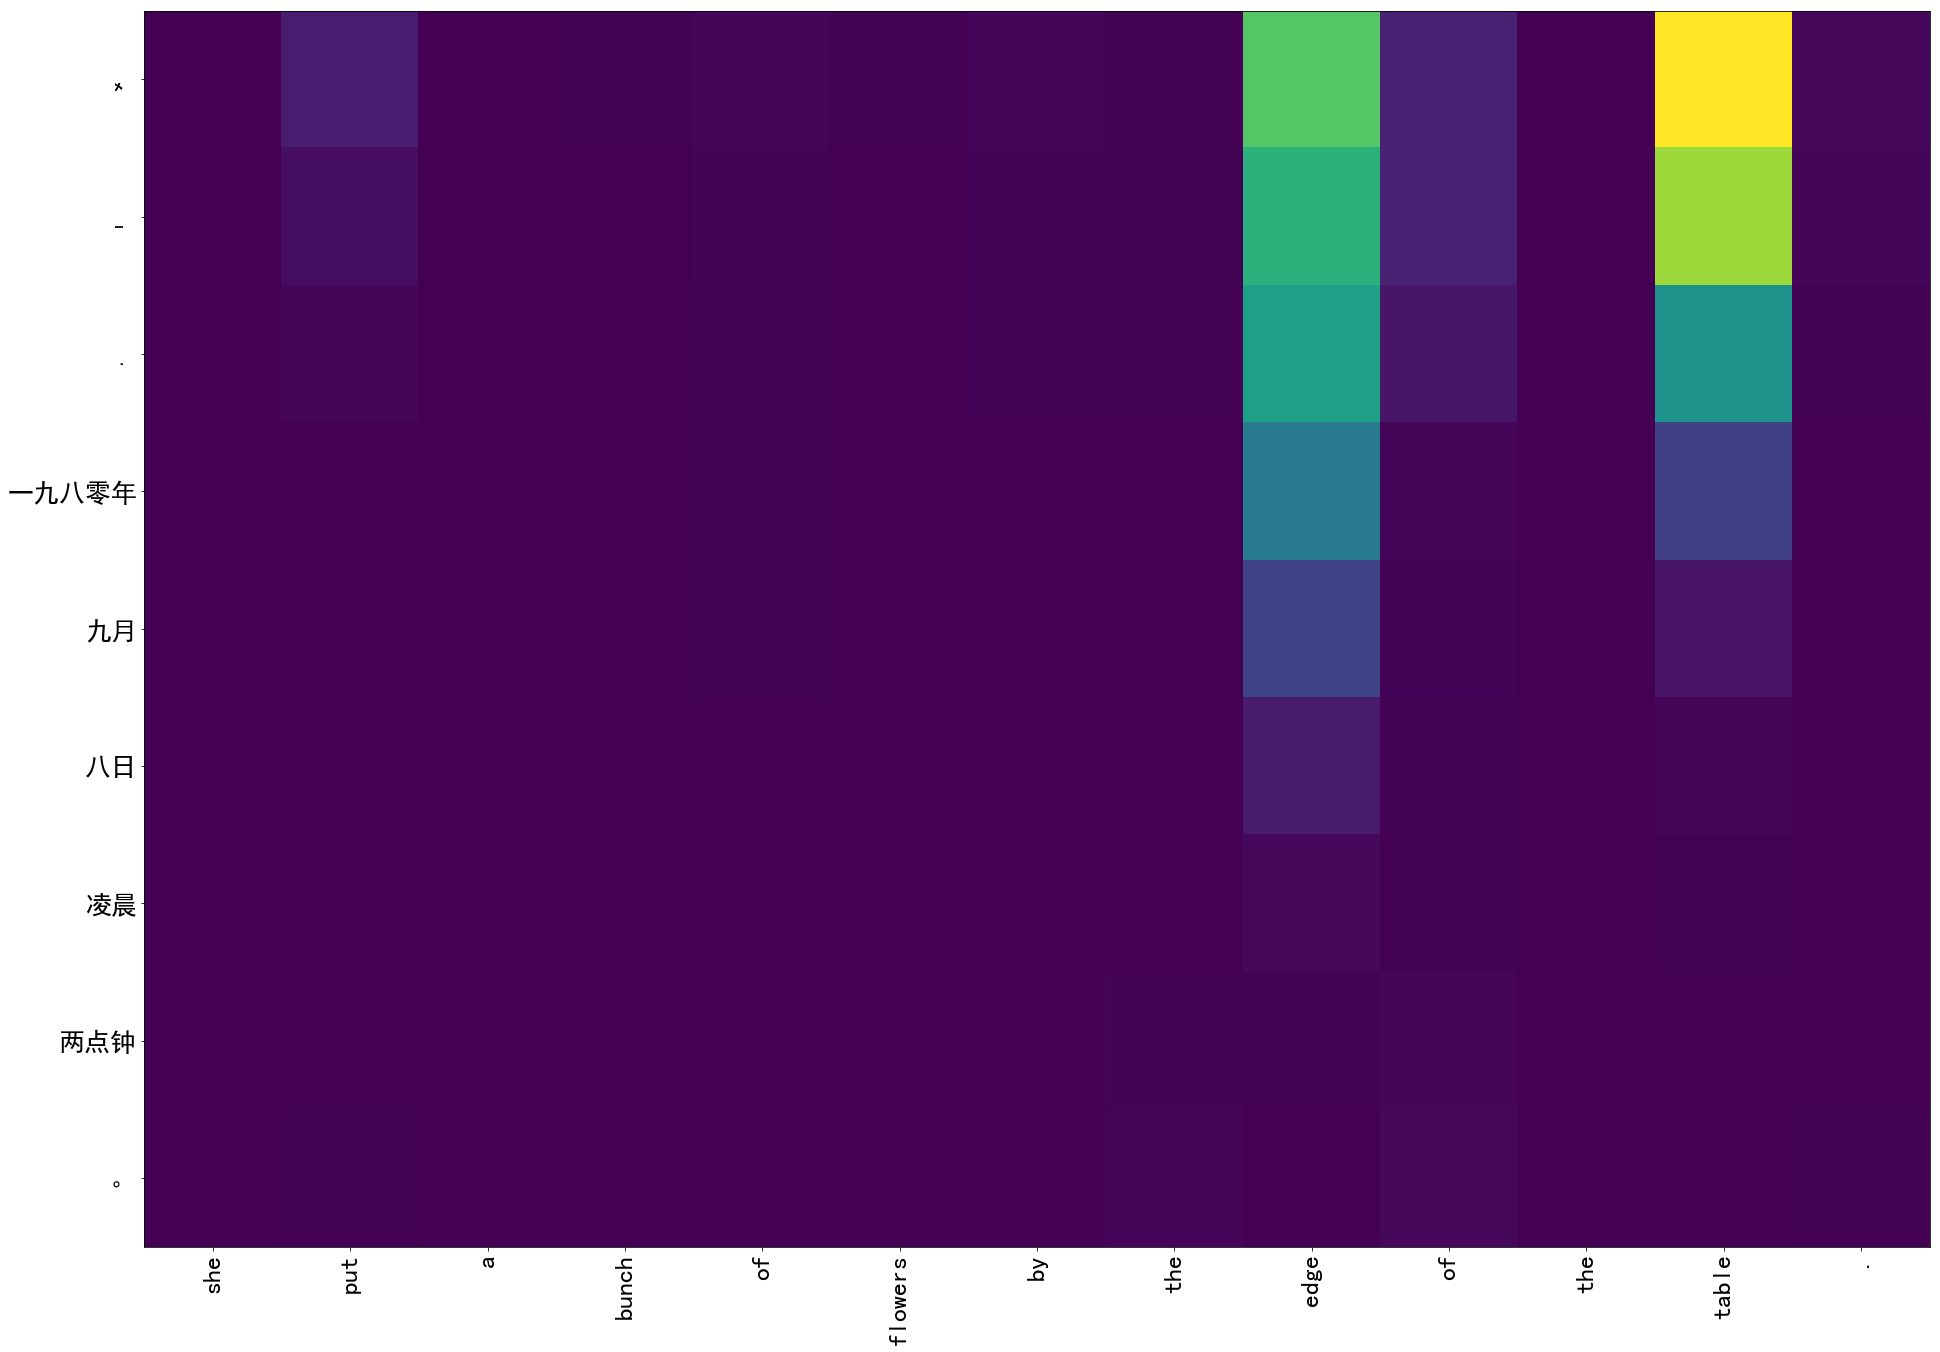

In [51]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence, attn_weights = decode_sequence(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence)
# Attention plotting
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights, index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0:10]))

Input Source sentence: 她 生 于 一九八零年 九月 八日 凌晨 两点钟 。
Actual Target Translation: she was born at two o clock in the morning september eighth 1980 .
Predicted Target Translation: she put a bunch of flowers by the edge of the table .


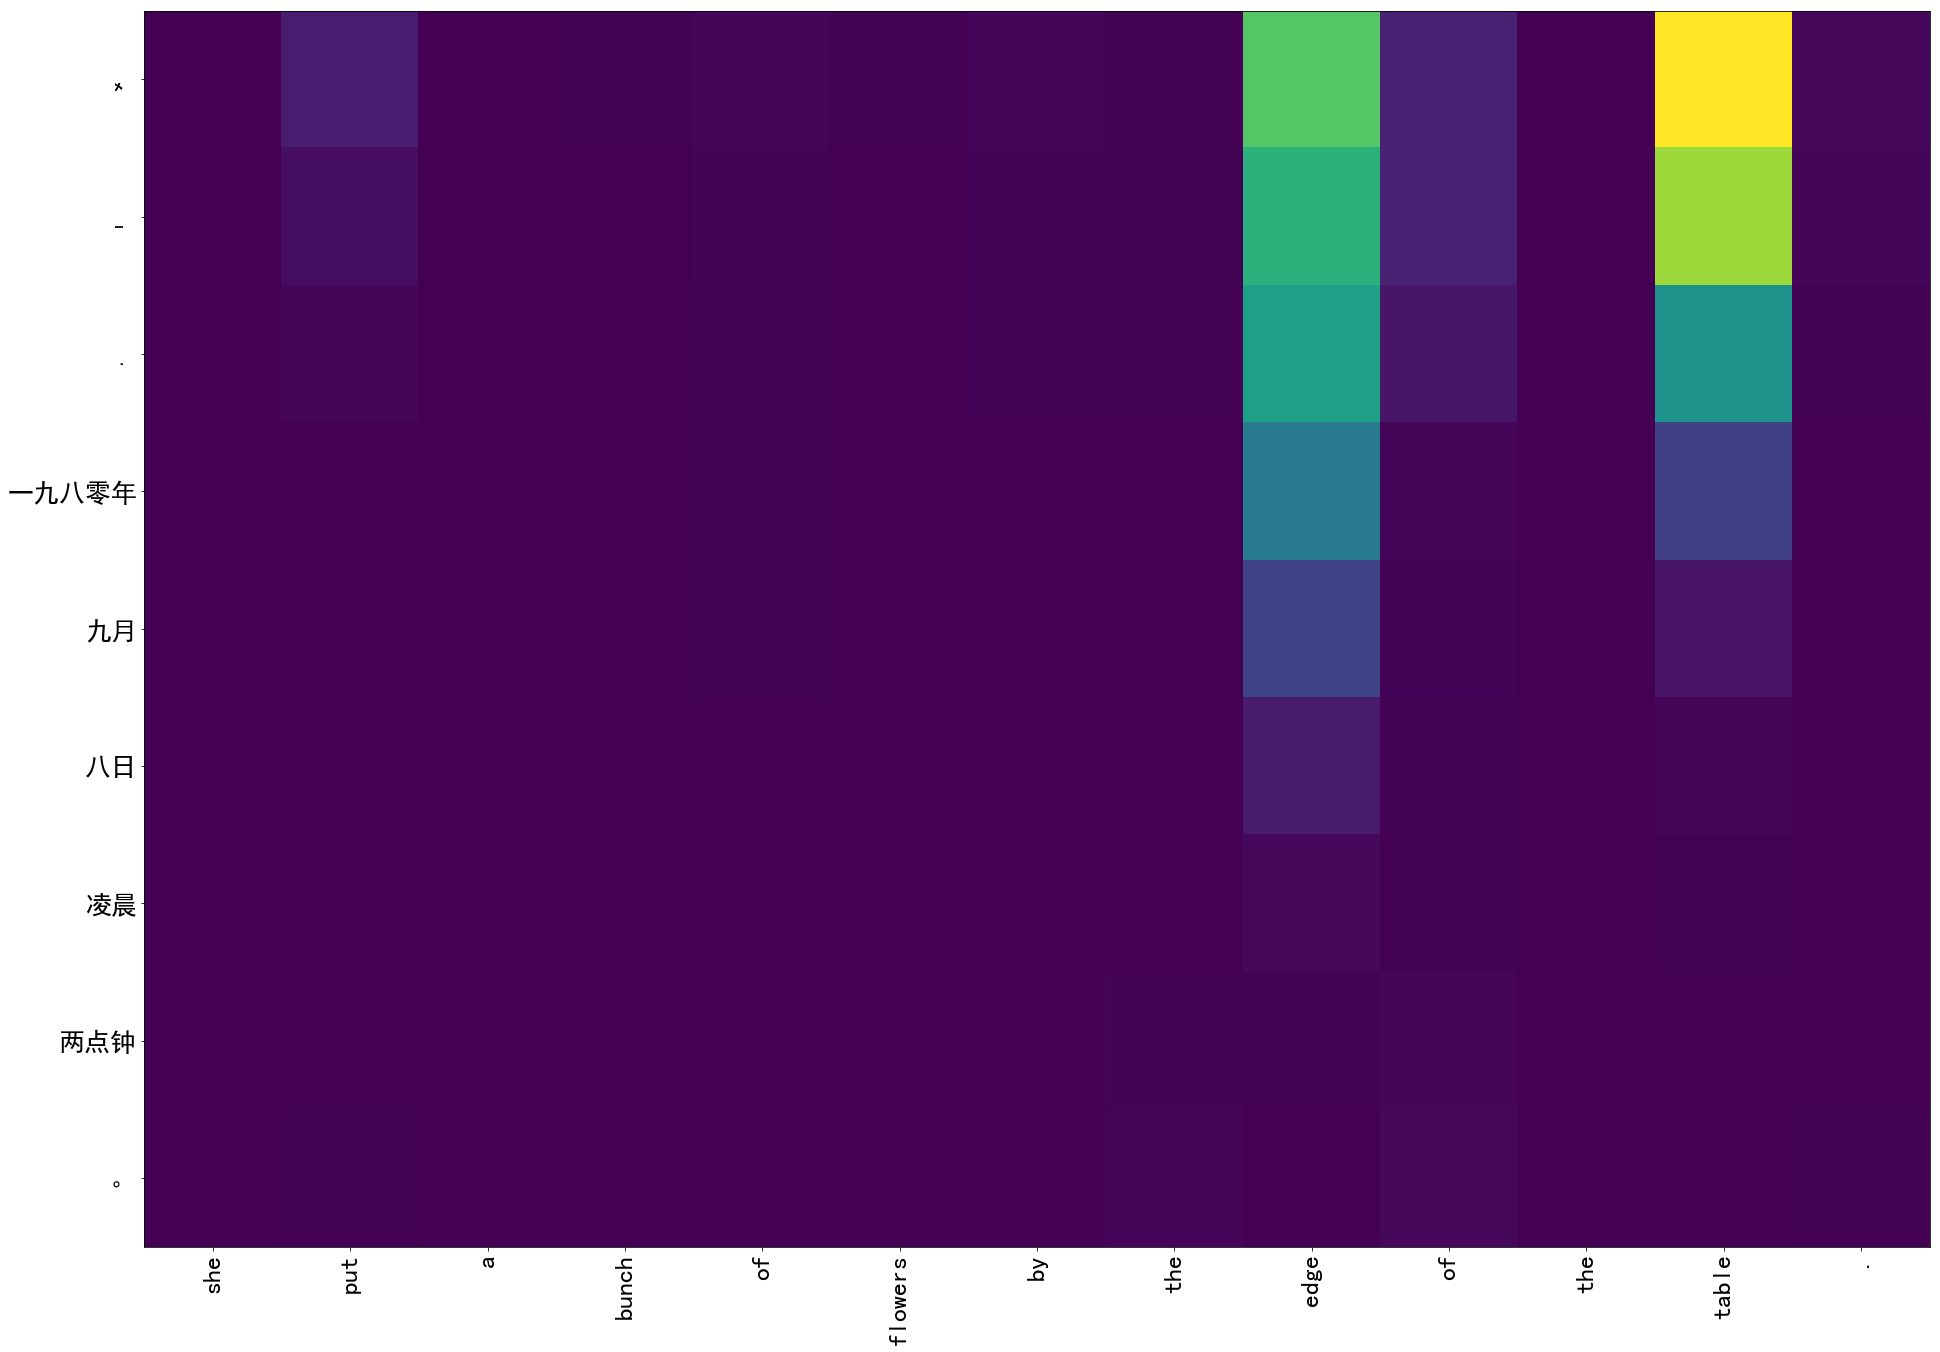

In [52]:
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [38]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['she', 'put', 'a', 'bunch', 'of', 'flowers', 'by', 'the', 'edge', 'of', 'the', 'table', '.']
Reference - Actual Target Translation: [['she', 'was', 'born', 'at', 'two', 'o', 'clock', 'in', 'the', 'morning', 'september', 'eighth', '1980', '.']]
Bleu score: 1.1692181040915729e-231


H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [39]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence, _ = decode_sequence(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence.split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence)
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 80

Input Source sentence: 我 可以 用纸 笔 写作 ， 要 算 统计 时 就 打算盘 。
Actual Target Translation: i may use pen for writing and use abacus for statistics .
Predicted Target Translation: i may use pen for writing and use abacus for statistics .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 80

Input Source sentence: 当 我 同 那些 意识 不到 离婚 会 对 子女 带来 巨大 打击 的 父母 交谈 时 ， 我 往往 为 之 震惊 。
Actual Target Translation: i m always taken aback when i communicate with parents who have no understanding of the devastation divorce cause s children .
Predicted Target Translation: i m always taken aback when i communicate with parents who have no understanding of the devastation divorce cause s children .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 80

Inp

Sample: 16 in total number of 80

Input Source sentence: 搜索 一 个 3 字母 的 单词 ， 比如 abc ， 可以 通过 搜索 ab 和 bc 来 实现 。
Actual Target Translation: a search for a 3 letter word , like abc , can be done by searching for ab and bc .
Predicted Target Translation: a search for a 3 letter word , like abc , can be done by searching for ab and bc .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 17 in total number of 80

Input Source sentence: 美国 成为 现今 世界 上 最 富有 的 国家 。
Actual Target Translation: the united states has become the richest country in the world .
Predicted Target Translation: the united states has become the richest country in the world .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 18 in total number of 80

Input Source sentence: 那 年 饥荒 饿死 了 几千 人 。
Actual Target Translation: thousands of people w

Sample: 35 in total number of 80

Input Source sentence: 为了 不 留下 指纹 ， 他们 一定 戴上 了 手套 。
Actual Target Translation: they must have worn gloves in order not to leave any fingerprints .
Predicted Target Translation: they must have worn gloves in order not to leave any fingerprints .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 36 in total number of 80

Input Source sentence: 我的 语法 当 其 条件 允许 时 找到 了 一 个 abc ， 但是 当 只 能 找到 a 或者 ab 时 ， 也 能 满足于 此 。
Actual Target Translation: my grammar finds an abc when it is available , but settles for an a , or ab , when that is all there is to find .
Predicted Target Translation: my grammar finds an abc when it is available , but settles for an a , or ab , when that is all there is to find .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 37 in total number of 80



Sample: 53 in total number of 80

Input Source sentence: 我 在 高中 学的 是 数学 微积分 ab 不 是 bc ， 我 得了 4 分 在 数学 微积分 考试 ap 中 不 是 5 分 。
Actual Target Translation: i had taken ab calculus during high school not bc , and had scored a 4 on the ap exam not a 5 .
Predicted Target Translation: i had taken ab calculus during high school not bc , and had scored a 4 on the ap exam not a 5 .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 54 in total number of 80

Input Source sentence: 关于 你 的 秘密 ， 我 决 不 会 向 别人 泄露 一 个 字 的 。
Actual Target Translation: i will not breathe a word of your secret to another man .
Predicted Target Translation: i will not breathe a word of your secret to another man .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 55 in total number of 80

Input Source sentence: 上 周 接受 观察者 访问 的 时候 ， 理查德 布

Sample: 70 in total number of 80

Input Source sentence: 如果 力矩 是 这样 地 作用 于 一 圆盘 上 ， 即 力矩 的 轴 与 圆盘 的 旋转 轴 方向 一致 ， 则 力矩 的 方向 与 ab 线 平行 。
Actual Target Translation: if a torque is applied to the disk in such a fashion that the axis of the torque is the same as that of rotation of the disk , the direction of the former will be parallel to ab .
Predicted Target Translation: if a torque is applied to the disk in such a fashion that the axis of the torque is the same as that of rotation of the disk , the direction of the former will be parallel to ab .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 71 in total number of 80

Input Source sentence: 既然 你 不 愿意 帮 我 的 忙 ， 我 就 要 自己 一 个 人 干 这个 工作 。
Actual Target Translation: since you won t help me , i must do the work myself .
Predicted Target Translation: since you won t help me , i must do the work myself .
Bleu score: 1.0
---------------------------

In [40]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 80

Input Source sentence: 我 可以 用纸 笔 写作 ， 要 算 统计 时 就 打算盘 。
Actual Target Translation: i may use pen for writing and use abacus for statistics .
Predicted Target Translation: i may use pen for writing and use abacus for statistics .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 80

Input Source sentence: 当 我 同 那些 意识 不到 离婚 会 对 子女 带来 巨大 打击 的 父母 交谈 时 ， 我 往往 为 之 震惊 。
Actual Target Translation: i m always taken aback when i communicate with parents who have no understanding of the devastation divorce cause s children .
Predicted Target Translation: i m always taken aback when i communicate with parents who have no understanding of the devastation divorce cause s children .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 80

Inp

Sample: 16 in total number of 80

Input Source sentence: 搜索 一 个 3 字母 的 单词 ， 比如 abc ， 可以 通过 搜索 ab 和 bc 来 实现 。
Actual Target Translation: a search for a 3 letter word , like abc , can be done by searching for ab and bc .
Predicted Target Translation: a search for a 3 letter word , like abc , can be done by searching for ab and bc .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 17 in total number of 80

Input Source sentence: 美国 成为 现今 世界 上 最 富有 的 国家 。
Actual Target Translation: the united states has become the richest country in the world .
Predicted Target Translation: the united states has become the richest country in the world .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 18 in total number of 80

Input Source sentence: 那 年 饥荒 饿死 了 几千 人 。
Actual Target Translation: thousands of people w

Sample: 34 in total number of 80

Input Source sentence: 他 是 我 的 朋友 。
Actual Target Translation: he is a friend of mine. he is one of my friends .
Predicted Target Translation: he is a friend of mine. he is one of my friends .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 35 in total number of 80

Input Source sentence: 为了 不 留下 指纹 ， 他们 一定 戴上 了 手套 。
Actual Target Translation: they must have worn gloves in order not to leave any fingerprints .
Predicted Target Translation: they must have worn gloves in order not to leave any fingerprints .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 36 in total number of 80

Input Source sentence: 我的 语法 当 其 条件 允许 时 找到 了 一 个 abc ， 但是 当 只 能 找到 a 或者 ab 时 ， 也 能 满足于 此 。
Actual Target Translation: my grammar finds an abc when it is available , but settles for an

Sample: 51 in total number of 80

Input Source sentence: 他 卖 了 房子 及 房 内 的 许多 家具 。
Actual Target Translation: he has sold his house and a lot of furniture in it .
Predicted Target Translation: he has sold his house and a lot of furniture in it .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 52 in total number of 80

Input Source sentence: 他 对 工厂 的 困难 毫 不 关心 。
Actual Target Translation: he is not concerned with the difficulties of the factory at all .
Predicted Target Translation: he is not concerned with the difficulties of the factory at all .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 53 in total number of 80

Input Source sentence: 我 在 高中 学的 是 数学 微积分 ab 不 是 bc ， 我 得了 4 分 在 数学 微积分 考试 ap 中 不 是 5 分 。
Actual Target Translation: i had taken ab calculus during high school not bc , and had s

Sample: 68 in total number of 80

Input Source sentence: 那 真 是 一 个 神奇 的 地方 ， ab 说 ， 但是 我们 住 的 酒店 很 糟糕 ， 而且 每天 都 吃 同样 的 食物 。
Actual Target Translation: it s an amazing place , ab said , but our hotel room was filthy and we ate the same thing every day .
Predicted Target Translation: it s an amazing place , ab said , but our hotel room was filthy and we ate the same thing every day .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 69 in total number of 80

Input Source sentence: 一些 评论 说 ， 用 算盘 计算 和 使用 计算器 毫 无 两样 ， 但是 ， 事实 并不 是 这样 。
Actual Target Translation: some might argue that dependence on an abacus is no different than dependence upon a calculator , but this is not at all the case .
Predicted Target Translation: some might argue that dependence on an abacus is no different than dependence upon a calculator , but this is not at all the case .
Bleu score: 1.0
-----------------------------

In [41]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence, _ = decode_sequence(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence)
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 20

Input Source sentence: 她 生 于 一九八零年 九月 八日 凌晨 两点钟 。
Actual Target Translation: she was born at two o clock in the morning september eighth 1980 .
Predicted Target Translation: she put a bunch of flowers by the edge of the table .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 20

Input Source sentence: 目的 研究 前列腺 非典型 腺瘤性 增生 aah 的 诊断 和 鉴别 诊断 。
Actual Target Translation: objective diagnosis and differential diagnosis of atypical adenomatous hyperplasia of the prostate aah were studied .
Predicted Target Translation: they presented a sum of money to the college in memory of their son .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 20

Input Source sentence: 他 说 ， 我 对 取消 补贴 和 消除 贸易 壁垒 未 能 排 得 更加 靠 前 感到 惊讶 。 他 还 表示 ， 他 对 气候 变化 问


Input Source sentence: ab 用 于 为 php 页面 自动化 处理 大量 的 请求 。
Actual Target Translation: use ab to automate a large number of requests for php pages .
Predicted Target Translation: the ab utility requests that url many times over and returns statistics .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 18 in total number of 20

Input Source sentence: 高盛 告诉 投资者 组成 cdo 的 合成 证券 阿巴卡斯 是 由 独立 的 抵押品 管理人 aca 公司 挑选 的 。
Actual Target Translation: it told investors that the securities bundled together to form the cdo , known as abacus , had been selected by an independent collateral manager , aca .
Predicted Target Translation: it is the only building i ve ever seen which is made entirely of glass .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 19 in total number of 20

Input Source sentence: 我们 看 一 个 人 ， 不 是 根据

In [42]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 20

Input Source sentence: 她 生 于 一九八零年 九月 八日 凌晨 两点钟 。
Actual Target Translation: she was born at two o clock in the morning september eighth 1980 .
Predicted Target Translation: she put a bunch of flowers by the edge of the table .
Bleu score: 1.1692181040915729e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 20

Input Source sentence: 目的 研究 前列腺 非典型 腺瘤性 增生 aah 的 诊断 和 鉴别 诊断 。
Actual Target Translation: objective diagnosis and differential diagnosis of atypical adenomatous hyperplasia of the prostate aah were studied .
Predicted Target Translation: they presented a sum of money to the college in memory of their son .
Bleu score: 1.2247502623754442e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 20

Input Source sentence: 他 说 ， 我 对 取消 补贴 和 消除 贸易 壁垒

Sample: 17 in total number of 20

Input Source sentence: ab 用 于 为 php 页面 自动化 处理 大量 的 请求 。
Actual Target Translation: use ab to automate a large number of requests for php pages .
Predicted Target Translation: the ab utility requests that url many times over and returns statistics .
Bleu score: 1.2627076138080564e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 18 in total number of 20

Input Source sentence: 高盛 告诉 投资者 组成 cdo 的 合成 证券 阿巴卡斯 是 由 独立 的 抵押品 管理人 aca 公司 挑选 的 。
Actual Target Translation: it told investors that the securities bundled together to form the cdo , known as abacus , had been selected by an independent collateral manager , aca .
Predicted Target Translation: it has the only building i ve ever seen which is made entirely of glass .
Bleu score: 5.662885494708189e-232
-------------------------------------------------------------------------------------------------------------------------